
#Finding Cliques in Protein-Protein Interaction Networks using SMT solvers

In this notebook, we will
look at SMT solvers and see how they can be used to formalize and solve otherwise difficult problems. Particularly, we will show how to find cliques in PPI networks using constraints on a set of boolean variables.


**Instructions:**
1. To get started, click on File on the top left and click "Save a copy in Drive."
This will give you an editable version of this document that you can use.
2. If you press `CMD`+`Enter` it runs the cell, and if you press `Shift`+`Enter` it runs the cell and goes to the next one.
3. Make sure you run all cells as you go through the notebook; some cells will not work properly unless the previous one
has been run too.
4. If you disconnect or are inactive for some time you should run all of the cells again.

## 0. Preliminaries (you should run this cell but there is no need to read it)

In [ ]:
!pip install z3-solver
!pip install git+https://github.com/crrivero/FormalMethodsTasting.git#subdirectory=core
from z3 import *
from tofmcore import showSolver, visualize_ppi_network, visualize_ppi_solution
import networkx as nx
import itertools
from IPython.display import clear_output
clear_output()

## Encoding constraints in Z3

The goal of this notebook is to teach you about formal methods;
particularly, how you can use existing formal verification tools
(in this case, Z3) to analyze and solve your own problems.
Before we get started, let's look at some basic things we can do with Z3.

### Boolean

Suppose you have the following three boolean constraints and you want to check if there's a solution (an assignment of the variables) that satisfies all of them:

$$ x_1 \lor x_2 \lor x_3 $$

$$ \neg x_1 \implies \neg x_2$$

$$  x_1 \land x_3  $$

Let's see how we can do this using Z3.

In [ ]:
s = Solver() # initialize Z3 solver

# initialize variables

x1 = Bool('x_1') # declaring that x_1 is a boolean variable in Z3 which will be referred to as x1 in Python
x2 = Bool('x_2')
x3 = Bool('x_3')

# Note: we can also initialize multiple variables like so: x1, x2, x3 = Bools('x_1 x_2 x_3')

# we use s.add(.) to add a constraint to our solver s
# constraints can be made using many different operations such as Or, And, Not,
# equality, etc.

# here's how we would add the constraints above to our solver:

s.add( Or( x1, x2, x3 ) ) # add the first constraint
s.add( Implies( Not(x1), Not(x2) ) ) # add the second constraint
s.add( And( x1, x3 ) ) # add the third constraint

In [ ]:
# to view the constraints in our solver, we can use the following:
print( s )
# this prints the constraints as they appear in Z3 using Z3's notation

For better readability, this notebook also has a custom print function to view our constraints in LaTeX format, like so:

In [ ]:
showSolver( s )

In [ ]:
# we can use s.check() to run the solver and check whether its satisfiable:
print ( s.check() )

 "sat" means our system of constraints is satisfiable

In [ ]:
# after using s.check(),  we can use s.model() to output a solution if one exsits
solution = s.model()
print( solution )

Let's modify our system of constraint a bit and see if it's still satisfiable. Suppose we want to check if there's a solution where $x_1 = \neg x_3$. Let's see how we would do this with Z3.

In [ ]:
s.add( x1 == Not(x3) )
showSolver( s )

In [ ]:
print( s.check() ) # check if solution exists with new constraint

"unsat" means the system is not satisfiable, i.e., there is no assignment on the variables $x_1$, $x_2$, and $x_3$ that satisfies all the constraints we gave to the solver. **Note that if we were to run s.model() now we would get an error.**

We can also add arithmetic constraints to boolean variables:

$$ x_1 + x_2 + x_3 = 1 $$

To model these types of constraints, Z3 converts True/False boolean values to 1/0 integer values.

In [ ]:
s = Solver() # initialize solver

# initialize variables
x1 = Bool('x_1')
x2 = Bool('x_2')
x3 = Bool('x_3')

s.add( x1 + x2 + x3 == 1 )

print( s )

Note how Z3 uses If conditions to convert boolean variables into integers.
Our custom printer function prints these without the if conditions for better readability.

In [ ]:
showSolver( s )

In [ ]:
print( s.check() ) # check if satisfiable
print( s.model() ) # print solution

Now it's your turn! Complete the code in the cell below to find a solution satisfying the following constraints:

$$ x_1 \lor x_2 \lor x_3 $$
$$ x_1 + x_2 = x_3 $$
$$ \neg x_1 \implies x_3 $$

In [ ]:
s = Solver() # initialize solver

# initialize variables
x1 = Bool('x_1')
x2 = Bool('x_2')
x3 = True # REPLACE THIS LINE

s.add( Or( x1, x2 ) ) # REPLACE THIS LINE
s.add( x1 + x2 == 1 ) # REPLACE THIS LINE
s.add( x2 == x2 )  # REPLACE THIS LINE

showSolver( s )
print( s.check() )
print( s.model() )

Note that Z3 does not support this boolean-to-integer conversion for every operator. For example, adding the constraint `x1 >= 1` or `x1 == 1` to our solver would give an error. Proper usage dictates using integers when using arithmetic constraints, but to keep things simple for our introductory notebook we will still work with booleans.

## Finding Cliques in PPI Networks

A clique in PPI network is a set of proteins that all interact with eachother. Below, we will model a PPI network and see how Z3 can be used to find cliques in it. As an example, we will find a clique in the following PPI network:

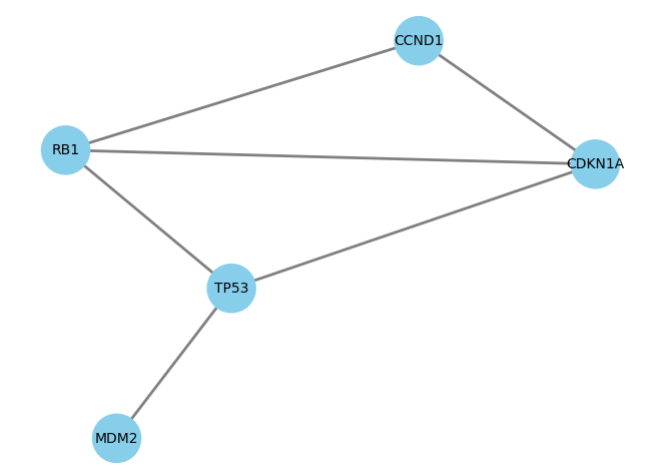

where the names of each node correspond to the following proteins:

| Protein   | Description                              |
|--------|------------------------------------------|
| TP53   | Tumor protein p53                        |
| MDM2   | E3 ubiquitin-protein ligase Mdm2         |
| CDKN1A | p21, cyclin-dependent kinase inhibitor   |
| CCND1  | Cyclin D1                                |
| RB1    | Retinoblastoma-associated protein        |

#### Step 1: Create boolean variables for each protein

In [ ]:
TP53, MDM2, CDKN1A, CCND1, RB1 = Bools("TP53 MDM2 CDKN1A CCND1 RB1")
proteins = [TP53, MDM2, CDKN1A, CCND1, RB1]

#### Step 2: Define the protein-protein interactions

In [ ]:
# We'll only list the positive interactions
# i.e., TP53 interacts with MDM2, CDKN1A, RB1
interactions = {
    (TP53, MDM2),
    (TP53, CDKN1A),
    (TP53, RB1),
    (CDKN1A, RB1),
    (CDKN1A, CCND1),
    (RB1, CCND1),
}

#### We have defined a function to visualize the network:

In [ ]:
visualize_ppi_network( interactions )

#### Step 3: Set size of clique

In [ ]:
k = 3 # size of the clique to find

#### Step 4: Set up Z3 solver

In [ ]:
s = Solver()

#### Step 5: Add constraints: if two proteins are selected, they must interact
For every unordered protein pair $P1$ and $P2$ that does NOT interact, add the constraint $ \neg (P1 \land P2) $, i.e., we can not select both $P1$ and $P2$ in our clique.

In [ ]:
# MDM2 and CDKN1A do not interact, so we cannot select them both
s.add( Not( And( MDM2, CDKN1A ) ) )
# Similarly:
s.add( Not( And( MDM2, CCND1 ) ) )
s.add( Not( And( MDM2, RB1 ) ) )
s.add( Not( And( TP53, CCND1 ) ) )

#### Step 6: Add constraints: select at least $k$ proteins

In [ ]:
s.add( TP53 + MDM2 + CDKN1A + CCND1 + RB1 >= k )

#### Step 7: Check solution

In [ ]:
# Check if solution exists
print( s.check() )

In [ ]:
# View solution
solution = s.model()
print( solution )


We have also defined a function to visualize the solution:

In [ ]:
visualize_ppi_solution( interactions, solution )

### Let's redo all the steps for another PPI network

| Protein   | Description                                         |
|--------|-----------------------------------------------------|
| TP53   | Tumor suppressor protein p53                        |
| MDM2   | E3 ubiquitin-protein ligase                         |
| CDKN1A | Cyclin-dependent kinase inhibitor p21               |
| CCND1  | Cyclin D1                                           |
| RB1    | Retinoblastoma-associated protein                   |
| AKT1   | RAC-alpha serine/threonine-protein kinase           |
| PIK3CA | Phosphatidylinositol 4,5-bisphosphate 3-kinase      |
| MTOR   | Mechanistic target of rapamycin                     |
| RPTOR  | Regulatory-associated protein of mTOR               |
| RICTOR | Rapamycin-insensitive companion of mTOR             |

This time, we will automate some of the process

#### Define boolean variables and interaction network

In [ ]:
TP53, MDM2, CDKN1A, CCND1, RB1, AKT1, PIK3CA, MTOR, RPTOR, RICTOR = Bools(
    "TP53 MDM2 CDKN1A CCND1 RB1 AKT1 PIK3CA MTOR RPTOR RICTOR"
)
proteins = [TP53, MDM2, CDKN1A, CCND1, RB1, AKT1, PIK3CA, MTOR, RPTOR, RICTOR]
interactions = {
    (TP53, MDM2),(TP53, CDKN1A),(TP53, CCND1),(TP53, RB1),(MDM2, CDKN1A),
    (MDM2, CCND1),(MDM2, RB1),(CDKN1A, CCND1),(CDKN1A, RB1),(CCND1, RB1),
    (AKT1, PIK3CA),(AKT1, MTOR),(AKT1, RPTOR),(AKT1, RICTOR),(PIK3CA, MTOR),
    (PIK3CA, RPTOR),(PIK3CA, RICTOR),(MTOR, RPTOR),(MTOR, RICTOR),(RPTOR, RICTOR),
    (TP53, AKT1),(MDM2, MTOR),(RB1, PIK3CA)
}
visualize_ppi_network( interactions )

#### Set up solver and find solution

In [ ]:
s = Solver()

# Set value of k
k = 5

# Tell solver to select k proteins
s.add ( Sum( proteins ) == k )

# Add clique constraints
for P1, P2 in itertools.combinations( proteins, 2 ):
  # if P1 and P2 do not interact...
  if ( (P1, P2) not in interactions and (P2, P1) not in interactions ):
    s.add( Not( And( P1, P2 ) ) ) # ... do not select them both in a solution

# Check if solution exists
print( s.check() )

# View solution
solution = s.model()
print( solution )

# Visualize solution
visualize_ppi_solution( interactions, solution )


### Congratulations! You just used an SMT solver to find cliques in PPI networks!


####If you'd like to continue your Z3 journey, you can start with this guide to learn more:
https://ericpony.github.io/z3py-tutorial/guide-examples.htm